# 이미지 분석
>complete
- toc: false
- badges: true
- comments: true
- categories: [Big Data Analysis]
- image: images/chart-preview.png

## Fastai를 이용한 강아지와 고양이 분류 모델 사용해보기

`-` 데이터 다운로드 및 전처리

In [1]:
#collapse_show
# Colab 환경일 시 아래의 명령어 실행 후 런타임 재시작 필요.
!pip install --upgrade fastai

     |████████████████████████████████| 189 kB 5.2 MB/s 
     |████████████████████████████████| 56 kB 4.6 MB/s 
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [1]:
from fastai.vision.all import *

In [2]:
path=untar_data(URLs.PETS)/'images'

In [3]:
path

Path('/root/.fastai/data/oxford-iiit-pet/images')

In [4]:
files = get_image_files(path)

In [5]:
files[2]

Path('/root/.fastai/data/oxford-iiit-pet/images/havanese_125.jpg')

- 고양이와 강아지 이미지는 파일명의 첫 글자가 각각 대문자, 소문자로 저장되어 있다.
- 파일명의 대소문자 구분을 통해 cat, dog를 구별해주는 함수를 구현한다.

In [6]:
def label_func(f):
    if f[0].isupper():
        return 'cat'
    else:
        return 'dog'

In [7]:
label_func('asdf')

'dog'

- 여기서 사용하는 데이터는 파일명을 통해 종속변수를 분류해놨기 때문에 from_name_func를 사용하여 ImageDataLoaders 오브젝트로 만들어준다.
- 인자로는 이미지가 위치한 경로와 파일명들, 위에 구현했던 함수, 이미지의 크기를 변환해주는 Resize함수를 사용한다.

In [8]:
dls=ImageDataLoaders.from_name_func(path, files, label_func, item_tfms=Resize(224))

`-` show_batch()를 사용한 이미지 preview

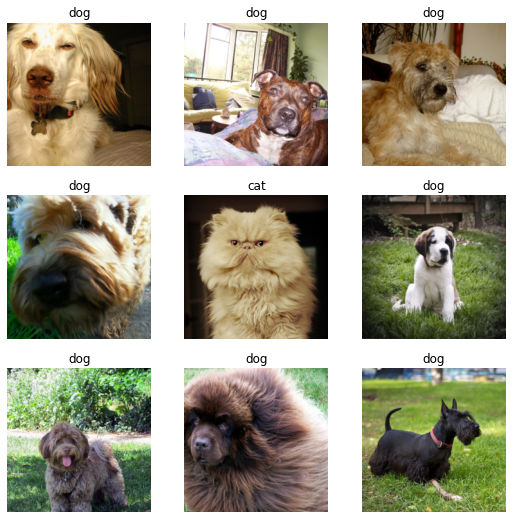

In [9]:
dls.show_batch()

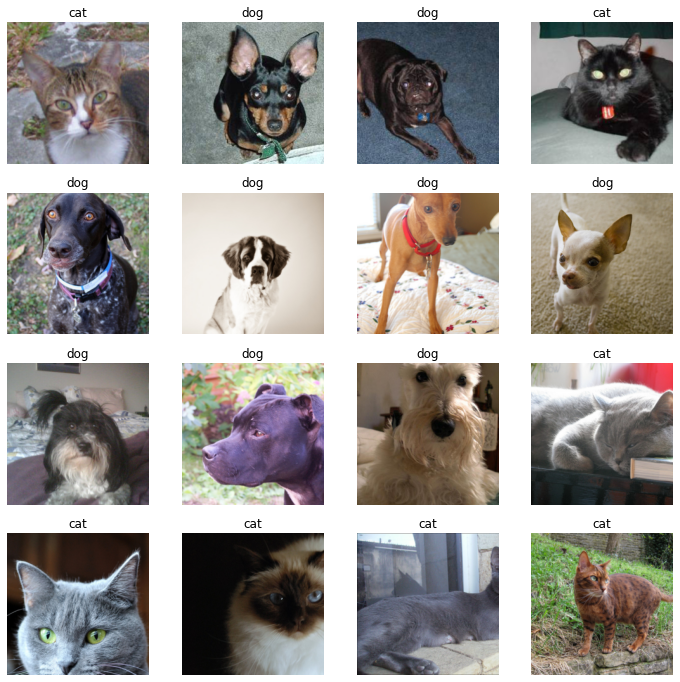

In [10]:
dls.show_batch(max_n=16)

`-` 모델 생성

In [11]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

- 만약 에러가 난다면 아래 코드를 실행한 뒤 커널을 재시작한다.

In [12]:
# !conda install -c conda-forge jupyterlab_widgets -y
# !conda install -c conda-forge ipywidgets -y
# !conda install -c conda-forge nodejs -y

`-` 학습 및 평가

In [13]:
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.137736,0.027261,0.007442,01:13


epoch,train_loss,valid_loss,error_rate,time
0,0.066873,0.024697,0.004736,01:17


`-` 예측

In [14]:
learn.predict(files[0])

('dog', TensorBase(1), TensorBase([3.6055e-07, 1.0000e+00]))

- 개일 확률은 매우 낮고, 고양이일 확률은 1로 매우 높다고 예측하였다.

`-` 예측 결과를 임의로 보려면?

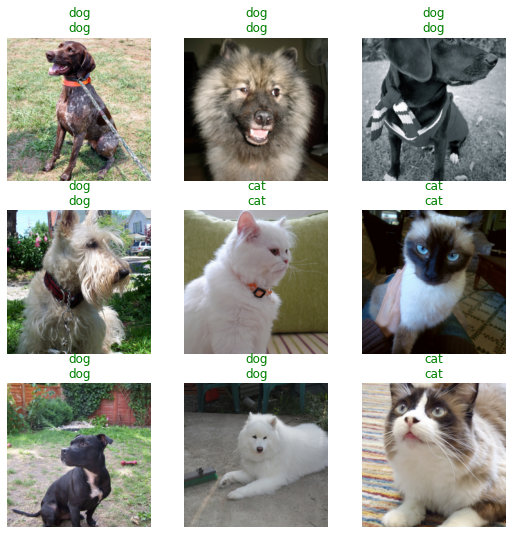

In [15]:
learn.show_results()

- 대체로 잘 맞추는 것을 확인할 수 있다.

`-` 오답분석

In [16]:
interp = Interpretation.from_learner(learn)

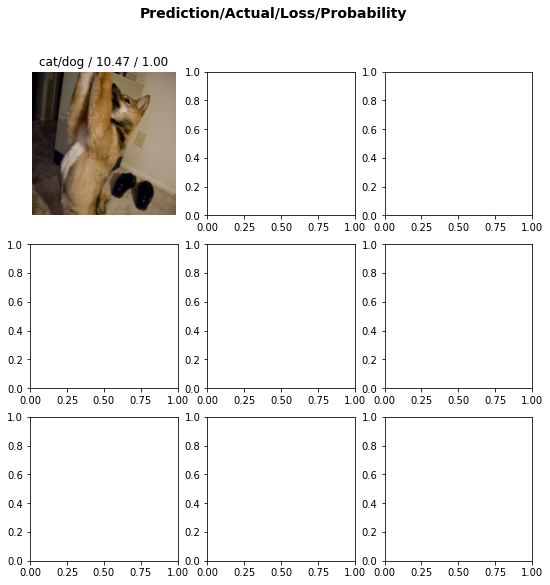

In [17]:
interp.plot_top_losses(9)

- plot_top_losses() 함수에 문제가 있어 제대로 출력되지 않는 모습이다. 임시로 코드를 고쳐서 사용해보자.

In [18]:
def plot_top_losses_fix(interp, k, largest=True, **kwargs):
        losses,idx = interp.top_losses(k, largest)
        if not isinstance(interp.inputs, tuple): interp.inputs = (interp.inputs,)
        if isinstance(interp.inputs[0], Tensor): inps = tuple(o[idx] for o in interp.inputs)
        else: inps = interp.dl.create_batch(interp.dl.before_batch([tuple(o[i] for o in interp.inputs) for i in idx]))
        b = inps + tuple(o[idx] for o in (interp.targs if is_listy(interp.targs) else (interp.targs,)))
        x,y,its = interp.dl._pre_show_batch(b, max_n=k)
        b_out = inps + tuple(o[idx] for o in (interp.decoded if is_listy(interp.decoded) else (interp.decoded,)))
        x1,y1,outs = interp.dl._pre_show_batch(b_out, max_n=k)
        if its is not None:
            #plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), L(self.preds).itemgot(idx), losses,  **kwargs)
            plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), interp.preds[idx], losses,  **kwargs)
        #TODO: figure out if this is needed
        #its None means that a batch knows how to show itself as a whole, so we pass x, x1
        #else: show_results(x, x1, its, ctxs=ctxs, max_n=max_n, **kwargs)

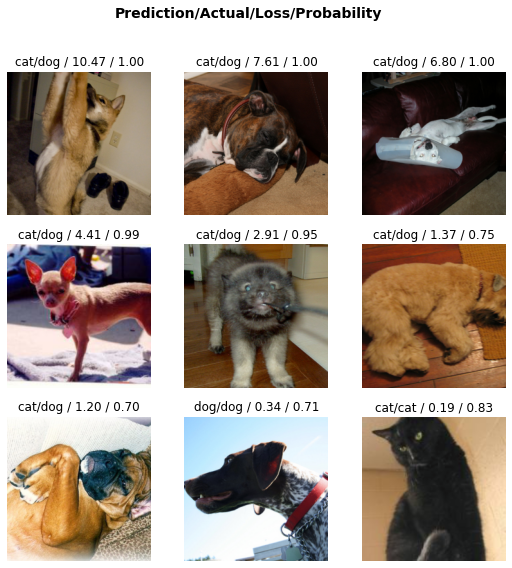

In [20]:
plot_top_losses_fix(interp, 9)